In [80]:
import torch
import torch.nn as nn
from d2l import torch as d2l
import os
#@save
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

In [81]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [82]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

## training-process

In [86]:
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',encoding='UTF-8') as f:
        return f.read()

In [89]:
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',encoding='UTF-8') as f:
        return f.read()
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = d2l.preprocess_nmt(read_data_nmt())
    source, target = d2l.tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len =d2l.build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len =d2l.build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

loss 0.020, 5910.7 tokens/sec on cuda:0


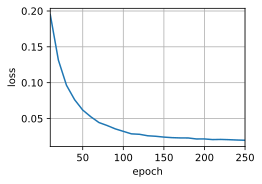

In [90]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 计算BLUE指数：

In [96]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng,fra in zip(engs,fras):
    translation,dec_attention_weight_seq=d2l.predict_seq2seq(net,eng,src_vocab,tgt_vocab,num_steps,device,True)
    print(f'{eng}=>{translation},',f'blue:{d2l.bleu(translation,fra,k=1):.3f}')

go .=>va !, blue:1.000
i lost .=>j'ai perdu ., blue:1.000
he's calm .=>il est paresseux ., blue:0.866
i'm home .=>je suis chez moi ., blue:1.000
